In [7]:
import os, sys
import h5py
import numpy as np
from scipy.io import loadmat
import cv2
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import matrix as mat
from sympy import *
from numpy import linalg as la

In [8]:
def getFx(para, frame):   # para中为(8*frame)的一套参数，frame传进来是为了确定循环次数
    #先写出参数表达式，ABDCDEF六个点的齐次坐标
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                     [0.0, 1147.59161666764, 508.064917088557],
                     [0.0, 0.0, 1.0]])
    w, x, y, z, tx, ty= symbols('w x y z tx ty')
    Rt = Matrix([[1-2*(y*y+z*z), 2*(x*y-z*w), 2*(x*z+y*w), tx], 
                      [2*(x*y+z*w), 1-2*(x*x+z*z), 2*(y*z-x*w), ty], 
                      [2*(x*z-y*w), 2*(y*z+x*w), 1-2*(x*x+y*y), 1]])  
    a, b, c, th, al = symbols('a b c th al')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
    XB = Matrix([[0], [c], [0], [1]])
    XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
    XD = Matrix([[-b * c], [0], [0], [1]])
    XE = Matrix([[0], [0], [0], [1]])
    XF = Matrix([[b * c], [0], [0], [1]])
    ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
    ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
    uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
    ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
    ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
    uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
    #根据每一帧的循环，提取出Rt的参数，K是公用的，代入参数写出3D坐标，并计算出u/w，v/w
    #写成f的形式，即按照六个点分块，每块里面有M帧
    getfx = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i == 0 :
                f = Matrix([ua/wa, va/wa])
            elif i == 1 :
                f = Matrix([ub/wb, vb/wb])
            elif i == 2 :
                f = Matrix([uc/wc, vc/wc])
            elif i == 3 :
                f = Matrix([ud/wd, vd/wd])
            elif i == 4 :
                f = Matrix([ue/we, ve/we])
            else:
                f = Matrix([uf/wf, vf/wf])
            f_value = f.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095})
            getfx[i*frame*2+j*2] = f_value[0]
            getfx[i*frame*2+j*2+1] = f_value[1]
    #返回getfx值，2*frame*6 by 1
    return getfx

In [9]:
def getJacobian(point, frame, para):
    # 用参数表示K，R矩阵
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                     [0.0, 1147.59161666764, 508.064917088557],
                     [0.0, 0.0, 1.0]])
    w, x, y, z, tx, ty= symbols('w x y z tx ty')
    Rt = Matrix([[1-2*(y*y+z*z), 2*(x*y-z*w), 2*(x*z+y*w), tx], 
                    [2*(x*y+z*w), 1-2*(x*x+z*z), 2*(y*z-x*w), ty], 
                      [2*(x*z-y*w), 2*(y*z+x*w), 1-2*(x*x+y*y), 1]])

    # 用参数表示ABCDEF六个点坐标
    a, b, c, th, al = symbols('a b c th al')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    if point == 0 :
        XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
        ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
        f = Matrix([ua/wa, va/wa])
    elif point == 1 :
        XB = Matrix([[0], [c], [0], [1]])
        ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
        f = Matrix([ub/wb, vb/wb])
    elif point == 2 :
        XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
        uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
        f = Matrix([uc/wc, vc/wc])
    elif point == 3 :
        XD = Matrix([[-b * c], [0], [0], [1]])
        ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
        f = Matrix([ud/wd, vd/wd])
    elif point == 4 :
        XE = Matrix([[0], [0], [0], [1]])
        ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
        f = Matrix([ue/we, ve/we])
    elif point == 5:
        XF = Matrix([[b * c], [0], [0], [1]])
        uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
        f = Matrix([uf/wf, vf/wf])
    args = Matrix([x, y, z, w, tx, ty, th, al])
    f_X1 = f[0,:].jacobian(args)
    f_X2 = f[1,:].jacobian(args)
    JA = Matrix([f_X1, f_X2])   # 2 by 16 matrix
    JA_value = JA.subs({x:para[8*frame], y:para[8*frame+1], z:para[8*frame+2], w:para[8*frame+3], 
                                    tx:para[8*frame+4], ty:para[8*frame+5], th:para[8*frame+6], 
                                    al:para[8*frame+7], a:0.35, b:0.25, c:-0.095})
    return JA_value

In [10]:
def getJ(para, frame):
    getj = mat(np.zeros((6*frame*2, 8*frame)))
    for m in range(6):
        for n in range(frame):
            JA_value = getJacobian(m, n, para)
            #print(JA_value)
            getj[2*(m*frame+n):2*(m*frame+n+1), 8*n:8*n+8] = JA_value[:, 0:8]
            #getj[2*(m*frame+n):2*(m*frame+n+1), -3:] = JA_value[:, -3:]
    return getj

In [11]:
def getE(getfx, frame, k, xkp):
    E = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i==0 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==1 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==2 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==3 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==4 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==5 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
    return E

In [12]:
def LM_opti(frame, ith, x2d, x_para, u=1, v=2, step_max=500):
    J = mat(np.zeros((6*frame*2, 8*frame)))
    E = mat(np.zeros((6*frame*2,1)))   # E = f(X) - b ;
    E_temp = mat(np.zeros((6*frame*2,1)))   # E_temp compare with E in L-M
    x_k = mat(x_para.copy())   #parameter initialization
    step = 0   # iteration steps
    mse_last = 0   # mse value after iteration each time
    
    # L-M Algorithm obtain optimal parameters
    while(step < step_max):
        step += 1
        mse, mse_temp = 0, 0

        # generate Jacobian Matrix and calculate E
        getfx = mat(np.zeros((6*frame*2,1)))
        getfx = getFx(x_k, frame)
        E = getE(getfx, frame, ith, x2d)   #单帧模式，第几帧，GT

        for i in range(6*frame*2):
            mse += E[i]**2
        mse /= 6*frame*2

        # get new J
        J = mat(np.zeros((6*frame*2, 8*frame)))
        J = getJ(x_k, frame)

        # delta X = ...
        #print(J.T * J)
        dx = mat(np.zeros((8*frame,1)))
        LM = u * mat(np.eye(8*frame))
        dx = -(J.T * J + LM).I * J.T * E
        x_k_temp = x_k.copy()
        x_k_temp += dx
        
        #Q normalization
        for update_q in range(frame):
            q1, q2, q3, q4 = x_k_temp[8*update_q], x_k_temp[8*update_q+1], x_k_temp[8*update_q+2], x_k_temp[8*update_q+3]
            norm = sqrt(q1**2+q2**2+q3**2+q4**2)
            x_k_temp[8*update_q] = q1/norm
            x_k_temp[8*update_q+1] = q2/norm 
            x_k_temp[8*update_q+2] = q3/norm 
            x_k_temp[8*update_q+3] = q4/norm

        # calculate E_temp with x_k_temp
        # copy from E with x_k
        getfx_temp = mat(np.zeros((6*frame*2,1)))
        getfx_temp = getFx(x_k_temp, frame)
        E_temp = getE(getfx_temp, frame, ith, x2d)

        for i in range(6*frame*2):
            mse_temp += E_temp[i]**2
        mse_temp /= 6*frame*2

        # segma value to choose optimization model
        segma = (mse - mse_temp)/((dx.T * (u * dx - J.T * E))[0,0])

        # calculate new u
        if segma > 0:
            s = 1.0/3.0
            v = 2
            x_k = x_k_temp
            mse = mse_temp
            u = u * max(s, 1-pow(2*segma,3))
            u = u[0,0]
        else:
            u = u * v
            v = v * 2
            x_k = x_k_temp
            
        print("step = %d, abs(mse-mse_last) = %.8f" %(step, abs(mse-mse_last)))
        if abs(mse-mse_last)<0.000001:
            break    
        mse_last = mse

    print("step = ", step)
    print("mse = ", mse_last)
    #print("parameter = ", x_k)
    
    return x_k

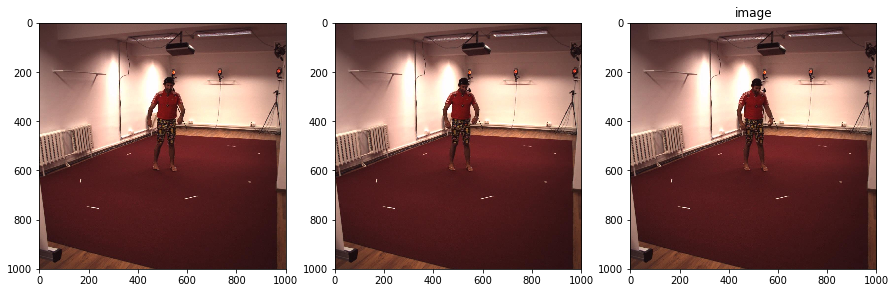

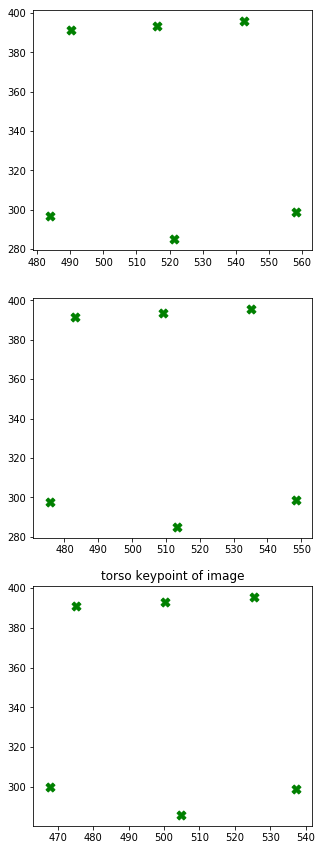

[[483.83330182 297.02895882]
 [475.6360488  297.90329019]
 [467.76985713 300.05987121]
 [521.42362196 285.01172463]
 [513.13288499 285.01206725]
 [504.68560881 285.88833555]
 [558.27002512 298.71850852]
 [548.54133329 298.82089764]
 [537.32923715 299.08072969]
 [490.11721691 391.47081586]
 [483.05709289 391.56314353]
 [475.17514487 390.94737465]
 [516.29540914 393.64693794]
 [509.17089976 393.55318747]
 [500.40525171 393.26600811]
 [542.46158091 395.86354434]
 [535.15509005 395.57472527]
 [525.29982451 395.59529855]]


In [13]:
frame = 3
m = loadmat("valid.mat")

# camera intrinsic matrix
K = m["annot"][0][0][4]
K_cam = K[0][0].tolist()

# key point 3D groundtruth
gt = m["annot"][0][0][3]
img_gt = np.zeros((frame, 3, 17))
img1_gt = gt[135]   # array 3 by 17
img2_gt = gt[136]   # array 3 by 17
img3_gt = gt[137]   # array 3 by 17
img_gt[0] = img1_gt
img_gt[1] = img2_gt
img_gt[2] = img3_gt
#print(img_gt)

# key point 2D groundtruth
kp = np.zeros((frame, 17, 2))
for m in range(frame):
    for i in range(17):
        u = K_cam[0] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        v = K_cam[1] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        w = K_cam[2] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        kp[m][i][0] = u/w
        kp[m][i][1] = v/w
#print(kp)

# show image
img1 = cv2.imread("S9_Posing_1.55011271_000676.jpg")
img2 = cv2.imread("S9_Posing_1.55011271_000681.jpg")
img3 = cv2.imread("S9_Posing_1.55011271_000686.jpg")
plt.figure(figsize = (15, 45)) # 图像窗口名称
plt.subplot(131)
plt.imshow(img1[:,:,[2,1,0]])
plt.subplot(132)
plt.imshow(img2[:,:,[2,1,0]])
plt.subplot(133)
plt.imshow(img3[:,:,[2,1,0]])
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

# visualize torso joints A-F
plt.figure(figsize = (5,15))
plt.subplot(311)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[0][i,0], kp[0][i,1], s = 80, c = 'g', marker = 'X')
plt.subplot(312)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[1][i,0], kp[1][i,1], s = 80, c = 'g', marker = 'X')
plt.subplot(313)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[2][i,0], kp[2][i,1], s = 80, c = 'g', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('torso keypoint of image') # 图像题目
plt.show()

# save 2D keypoint coordinate
x2d = np.zeros((6 * frame,2))   #[AAABBBCCCDDDEEEFFF].T
for i in range(6):
    for j in range(frame):
        if i==0 :
            x2d[i*frame+j, :] = kp[j][14, :]
        elif i==1 :
            x2d[i*frame+j, :] = kp[j][8, :]
        elif i==2 :
            x2d[i*frame+j, :] = kp[j][11, :]
        elif i==3 :
            x2d[i*frame+j, :] = kp[j][4, :]
        elif i==4 :
            x2d[i*frame+j, :] = kp[j][0, :]
        elif i==5 :
            x2d[i*frame+j, :] = kp[j][1, :]
print(x2d)

In [14]:
# parameter initialization for first frame (x,y,z,w,tx,ty,th,al | a,b,c)
x_para = np.zeros((8,1))
x_para[0] = 0   # q(x)
x_para[1] = 1   # q(y)
x_para[2] = 0   # q(z)
x_para[3] = 0   # q(w)
x_para[4] = 0.0047   #tx(cal)
x_para[5] = -0.0997   #ty(cal)
x_para[6] = 0   # th
x_para[7] = 0   #al
#x_para[-3] = 0.35   # a
#x_para[-2] = 0.25   # b
#x_para[-1] = -0.095  # c(cal)
getfx_ini = getFx(x_para, 1)
print(getfx_ini)

[[476.02538041]
 [284.62882932]
 [514.25209744]
 [284.62882932]
 [552.47881446]
 [284.62882932]
 [486.94729956]
 [393.65003291]
 [514.25209744]
 [393.65003291]
 [541.55689531]
 [393.65003291]]


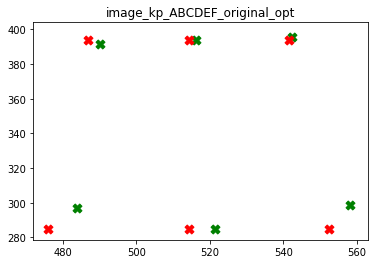

In [15]:
# visualize first frame after initilization
plt.figure()
img_kp = plt.scatter(kp[0][14,0], kp[0][14,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[0,0], getfx_ini[1,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][8,0], kp[0][8,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[2,0], getfx_ini[3,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][11,0], kp[0][11,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[4,0], getfx_ini[5,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][4,0], kp[0][4,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[6,0], getfx_ini[7,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][0,0], kp[0][0,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[8,0], getfx_ini[9,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][1,0], kp[0][1,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[10,0], getfx_ini[11,0], s = 80, c = 'r', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp_ABCDEF_original_opt') # 图像题目
plt.show()

In [16]:
# optimization for each frame
X_para = np.zeros((8*frame,1))
#X_para[-3] = 0.35   # a
#X_para[-2] = 0.25   # b
#X_para[-1] = -0.095  # c(cal)
para_data = np.zeros((frame,8))   # save each frame's initialization parameter
x_k_para = x_para.copy()
for i in range(frame):
    x_k = LM_opti(1, i, x2d, x_k_para)   #单帧优化，第几帧，GT，初始化参数

    print("\nFor the No.", i+1, " frame : x_k = ", x_k)
    para_data[i] = mat(x_k).T
    # for next frame initilization
    x_k_para = x_k
    X_para[8*i:8*i+8] = x_k[0:8,0]   #save parameters for global Bundle Adjustment
print(para_data)
print(X_para)

step = 1, abs(mse-mse_last) = 38.29289273
step = 2, abs(mse-mse_last) = 28.39988047
step = 3, abs(mse-mse_last) = 0.47630187
step = 4, abs(mse-mse_last) = 0.06414766
step = 5, abs(mse-mse_last) = 0.00000000
step =  5
mse =  [[9.35256273]]

For the No. 1  frame : x_k =  [[-0.03172096]
 [ 0.98995575]
 [-0.12828207]
 [ 0.05025041]
 [ 0.00651697]
 [-0.09967906]
 [ 0.16674078]
 [ 0.18626365]]
step = 1, abs(mse-mse_last) = 10.18696481
step = 2, abs(mse-mse_last) = 0.00000000
step =  2
mse =  [[10.18696481]]

For the No. 2  frame : x_k =  [[-2.41812822e-02]
 [ 9.88700196e-01]
 [-1.34147837e-01]
 [ 6.23822602e-02]
 [ 2.88641105e-04]
 [-9.97669594e-02]
 [ 1.84457688e-02]
 [-1.27532792e-01]]
step = 1, abs(mse-mse_last) = 22.43796795
step = 2, abs(mse-mse_last) = 11.16315841
step = 3, abs(mse-mse_last) = 0.00000000
step =  3
mse =  [[11.27480954]]

For the No. 3  frame : x_k =  [[-0.02587908]
 [ 0.98521556]
 [-0.15000481]
 [ 0.07860748]
 [-0.00738876]
 [-0.10002317]
 [ 0.12848023]
 [ 0.0086954 ]]

In [17]:
def visual2D(kp, getfx):
    plt.figure()
    img_kp = plt.scatter(kp[14,0], kp[14,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[0,0], getfx[1,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[8,0], kp[8,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[2,0], getfx[3,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[11,0], kp[11,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[4,0], getfx[5,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[4,0], kp[4,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[6,0], getfx[7,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[0,0], kp[0,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[8,0], getfx[9,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[1,0], kp[1,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[10,0], getfx[11,0], s = 80, c = 'r', marker = 'X')
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image_kp_ABCDEF_original_opt') # 图像题目
    plt.show()

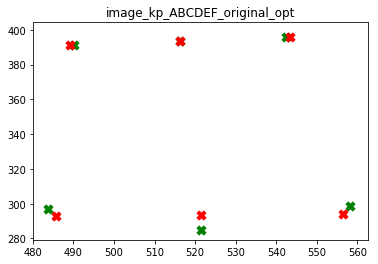

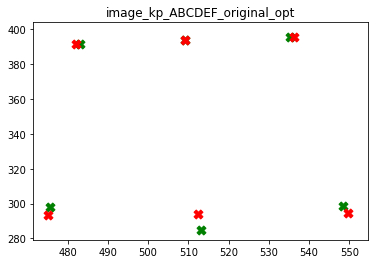

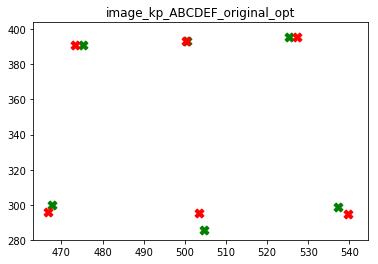

In [18]:
visual = np.zeros((8,1))
for i in range(frame):
    visual = mat(para_data[i]).T
    getfx_visual = getFx(visual, 1)
    visual2D(kp[i], getfx_visual)

In [19]:
def visual3D(img_gt, para):
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                 [0.0, 1147.59161666764, 508.064917088557],
                 [0.0, 0.0, 1.0]])
    w, x, y, z, tx, ty= symbols('w x y z tx ty')
    Rt = Matrix([[1-2*(y*y+z*z), 2*(x*y-z*w), 2*(x*z+y*w), tx], 
                    [2*(x*y+z*w), 1-2*(x*x+z*z), 2*(y*z-x*w), ty], 
                      [2*(x*z-y*w), 2*(y*z+x*w), 1-2*(x*x+y*y), 1]])  
    a, b, c, th, al = symbols('a b c th al')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
    XB = Matrix([[0], [c], [0], [1]])
    XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
    XD = Matrix([[-b * c], [0], [0], [1]])
    XE = Matrix([[0], [0], [0], [1]])
    XF = Matrix([[b * c], [0], [0], [1]])
    A3D = Rt * XA
    B3D = Rt * XB
    C3D = Rt * XC
    D3D = Rt * XD
    E3D = Rt * XE
    F3D = Rt * XF
    j = 0
    Y = mat([img_gt[0][0], img_gt[1][0], img_gt[2][0]]).T
    s = Y[2,0]
    print(s)

    A3D_value = A3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    B3D_value = B3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    C3D_value = C3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    D3D_value = D3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    E3D_value = E3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    F3D_value = F3D.subs({x:para[8*j], y:para[8*j+1], z:para[8*j+2], w:para[8*j+3], 
                                    tx:para[8*j+4], ty:para[8*j+5], th:para[8*j+6], 
                                    al:para[8*j+7], a:0.35, b:0.25, c:-0.095}) * s
    print(A3D_value,B3D_value,C3D_value,D3D_value,E3D_value,F3D_value)
    
    X1 = mat([img_gt[0][14], img_gt[1][14], img_gt[2][14]]).T
    X2 = mat([img_gt[0][8], img_gt[1][8], img_gt[2][8]]).T
    X3 = mat([img_gt[0][11], img_gt[1][11], img_gt[2][11]]).T
    X4 = mat([img_gt[0][4], img_gt[1][4], img_gt[2][4]]).T
    X5 = mat([img_gt[0][0], img_gt[1][0], img_gt[2][0]]).T
    X6 = mat([img_gt[0][1], img_gt[1][1], img_gt[2][1]]).T
    print(X1, X2, X3, X4, X5, X6)
    
    # 绘制散点图
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X1[0], X1[1], X1[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X2[0], X2[1], X2[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X3[0], X3[1], X3[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X4[0], X4[1], X4[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X5[0], X5[1], X5[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X6[0], X6[1], X6[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(A3D_value[0], A3D_value[1], A3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(B3D_value[0], B3D_value[1], B3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(C3D_value[0], C3D_value[1], C3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(D3D_value[0], D3D_value[1], D3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(E3D_value[0], E3D_value[1], E3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(F3D_value[0], F3D_value[1], F3D_value[2], s = 80, c = 'r', marker = 'X')

    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
    plt.show()
    
    # 计算3D error
    d1 = A3D_value-X1
    e1 = sum(map(lambda x:x**2, d1))
    d2 = B3D_value-X2
    e2 = sum(map(lambda x:x**2, d2))
    d3 = C3D_value-X3
    e3 = sum(map(lambda x:x**2, d3))
    d4 = D3D_value-X4
    e4 = sum(map(lambda x:x**2, d4))
    d5 = E3D_value-X5
    e5 = sum(map(lambda x:x**2, d5))
    d6 = F3D_value-X6
    e6 = sum(map(lambda x:x**2, d6))
    error = (e1**(0.5)+e2**(0.5)+e3**(0.5)+e4**(0.5)+e5**(0.5)+e6**(0.5))/6
    print(error)
    print(d1,d2,d3,d4,d5,d6)

5431.021804471869
Matrix([[-110.561469143726], [-1031.88007905501], [5508.29043523276]]) Matrix([[61.1458983327785], [-1039.28674726987], [5563.71056093585]]) Matrix([[232.853265809283], [-1046.69341548472], [5619.13068663893]]) Matrix([[-92.6819542481966], [-551.123066591708], [5419.23848947937]]) Matrix([[35.3938258450070], [-541.359136886105], [5431.02180447187]]) Matrix([[163.469605938211], [-531.595207180502], [5442.80511946437]])
[[-116.13794622]
 [-981.55022671]
 [5337.56816021]] [[   58.10612376]
 [-1032.54818762]
 [ 5312.38145874]] [[ 229.57596842]
 [-974.23751811]
 [5340.55881868]] [[ -88.47243168]
 [-551.69897883]
 [5430.16427386]] [[  35.17832488]
 [-541.48752095]
 [5431.02180447]] [[ 158.81323565]
 [-531.08752521]
 [5431.94416176]]


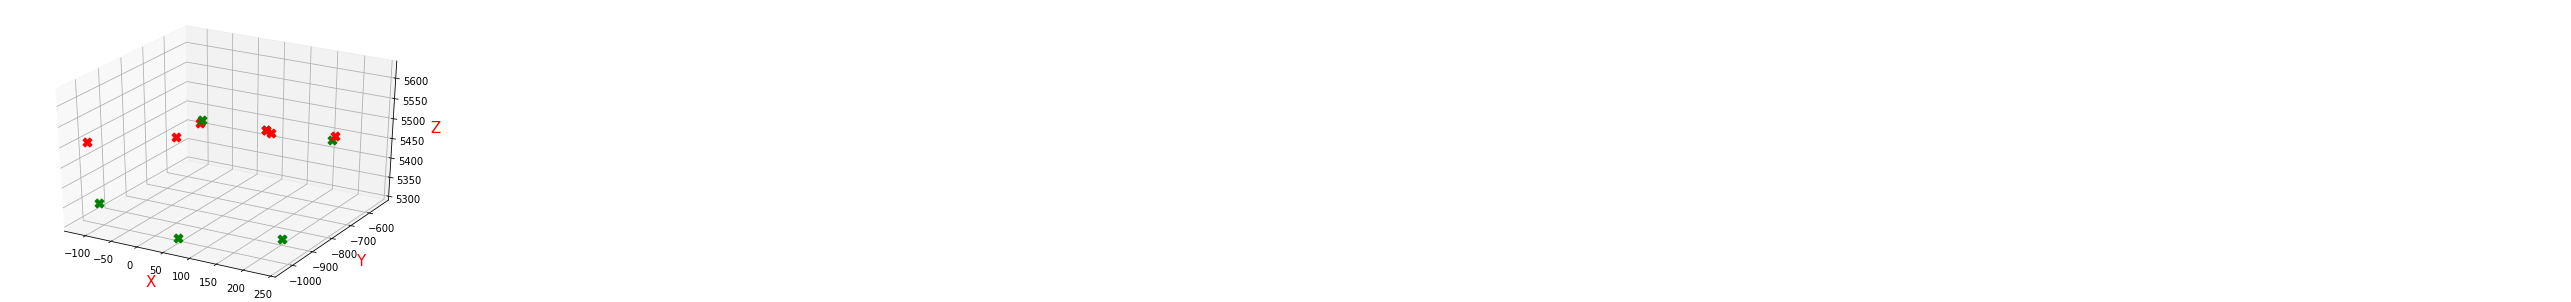

123.528725588595
Matrix([[5.57647707775237], [-50.3298523433087], [170.722275021169]]) Matrix([[3.03977457243680], [-6.73855964523364], [251.329102192759]]) Matrix([[3.27729738608090], [-72.4558973709034], [278.571867961580]]) Matrix([[-4.20952257211421], [0.575912237100397], [-10.9257843790210]]) Matrix([[0.215500965748255], [0.128384065456089], [0]]) Matrix([[4.65637029089368], [-0.507681967863846], [10.8609577056495]])
5433.287829883042
Matrix([[-163.031538542211], [-1041.37619161149], [5571.90031980740]]) Matrix([[17.6101758722899], [-1039.04396872398], [5571.76435489715]]) Matrix([[198.251890286790], [-1036.71174583647], [5571.62838998689]]) Matrix([[-126.317071965270], [-550.392559171208], [5418.20724729844]]) Matrix([[1.56827020053039], [-542.062606417814], [5433.28782988304]]) Matrix([[129.453612366331], [-533.732653664420], [5448.36841246764]])
[[-153.68046148]
 [-974.22112528]
 [5319.75324258]] [[   19.80977102]
 [-1033.23488078]
 [ 5315.92260793]] [[ 185.50850613]
 [-979.702

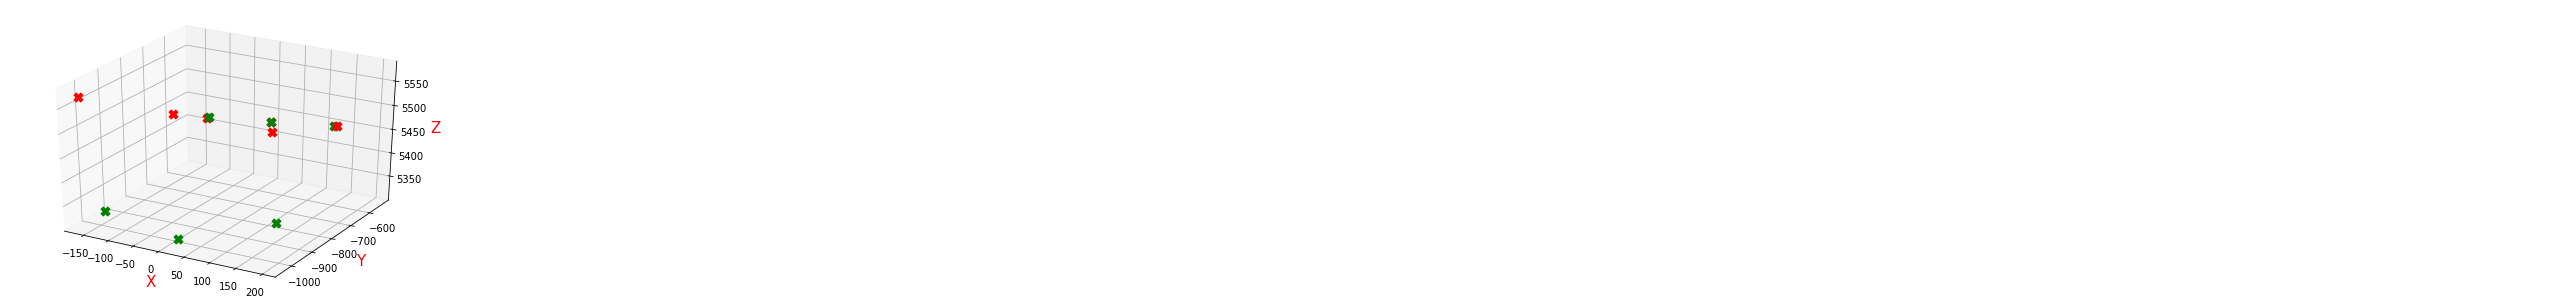

122.396005976188
Matrix([[-9.35107706372690], [-67.1550663298578], [252.147077229205]]) Matrix([[-2.19959514730023], [-5.80908794506718], [255.841746971516]]) Matrix([[12.7433841549553], [-57.0095128759455], [198.485241866985]]) Matrix([[-4.72120138915811], [-0.139756531811713], [-2.01498659977278]]) Matrix([[0.0452061211377677], [0.0947062243709524], [0]]) Matrix([[4.83063384260150], [0.140669448010726], [1.95090641845036]])
5450.435931254344
Matrix([[-203.726249986084], [-1030.68045851457], [5570.71489126145]]) Matrix([[-26.0793507416026], [-1038.96561680510], [5605.58836189551]]) Matrix([[151.567548502879], [-1047.25077509564], [5640.46183252957]]) Matrix([[-167.946700638484], [-554.823566272812], [5431.39070248696]]) Matrix([[-40.2719884237555], [-545.169869391100], [5450.43593125434]]) Matrix([[87.4027237909726], [-535.516172509387], [5469.48116002173]])
[[-189.06316845]
 [-959.07244598]
 [5291.33076613]] [[  -19.20508812]
 [-1026.82118409]
 [ 5303.76052482]] [[ 133.64030616]
 [-9

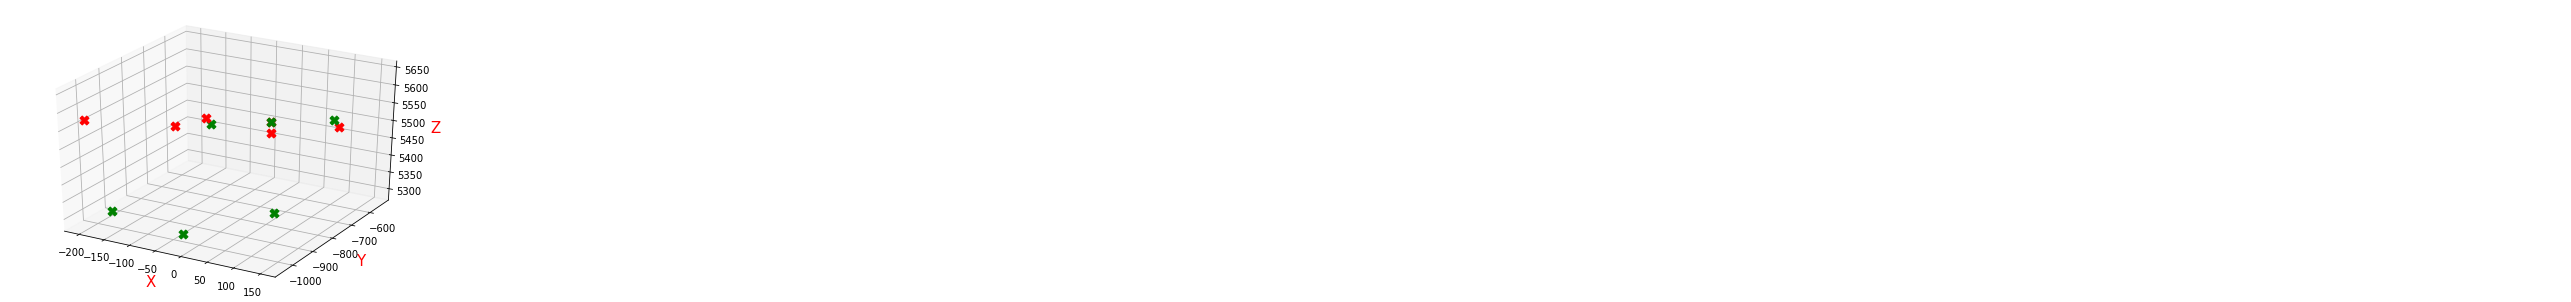

147.423433792159
Matrix([[-14.6630815355102], [-71.6080125351333], [279.384125130769]]) Matrix([[-6.87426262632454], [-12.1444327138108], [301.827837077352]]) Matrix([[17.9272423445755], [-64.8481755058907], [245.809722729069]]) Matrix([[-9.35514547607912], [-2.23482256650675], [16.7773446800747]]) Matrix([[-0.243268260860134], [0.0625018449820800], [0]]) Matrix([[8.89671655160603], [2.16946939626871], [-16.8318821955245]])


In [20]:
visual3d = np.zeros((8,1))
for i in range(frame):
    visual3d = mat(para_data[i]).T
    visual3D(img_gt[i], visual3d)